In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score

# Reading training data

In [2]:
train_data = pd.read_csv('train_data.txt', sep=':::', names=['title', 'genre', 'description'], engine='python')

In [3]:
train_data

,title,genre,description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [4]:
train_data['genre'].describe()

count       54214
unique         27
top        drama 
freq        13613
Name: genre, dtype: object

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54214 non-null  object
 1   genre        54214 non-null  object
 2   description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
train_data.isnull().sum()

title          0
genre          0
description    0
dtype: int64

# Reading testing data

In [7]:
test_data = pd.read_csv('test_data_solution.txt', sep=':::', names=['title', 'genre', 'description'], engine='python')

In [8]:
test_data.head()

,title,genre,description
1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [9]:
test_data.shape

(54200, 3)

In [10]:
test_data.isnull().sum()

title          0
genre          0
description    0
dtype: int64

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:


# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['text_cleaning'] = train_data['description'].apply(clean_text)
test_data['text_cleaning'] = test_data['description'].apply(clean_text)

# Merged training and testing data

In [13]:
movie_dataset = pd.concat([train_data, test_data], axis=0)
movie_dataset

,title,genre,description,text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...
...,...,...,...,...
54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Da...",covering multiple genres tales light dark anth...
54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their...,alice cora munro attempt find father british o...
54198,Oliver Twink (2007),adult,A movie 169 years in the making. Oliver Twist...,movie years making oliver twist artful dodger ...
54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard...",popular mysterious rock mike mallard askew bro...


<Axes: xlabel='count', ylabel='genre'>

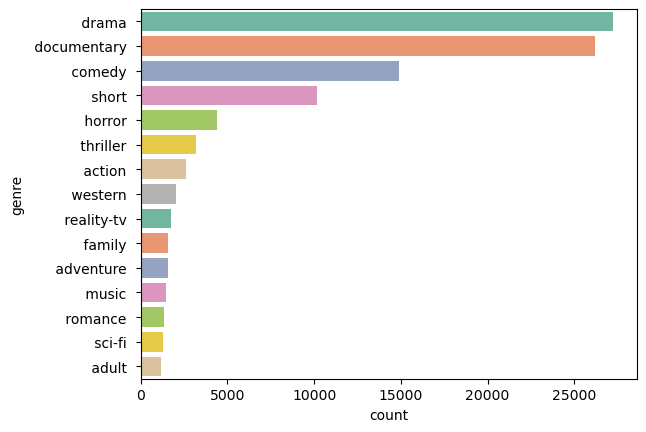

In [14]:
sns.countplot(y='genre', data=movie_dataset, palette="Set2", order=movie_dataset['genre'].value_counts().index[0:15])

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
movie_dataset['genre']=encoder.fit_transform(movie_dataset['genre'])

In [ ]:
movie_dataset

In [ ]:
movie_dataset=movie_dataset.drop(columns=['title'])

In [ ]:
movie_dataset.head()

# Modeling Data

In [ ]:
# Split the data into training and validation sets
X = movie_dataset['text_cleaning']
y = movie_dataset['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_traintrans = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_testtrans = tfidf_vectorizer.transform(X_test)

In [ ]:


# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_traintrans, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_testtrans)

# Evaluate the performance of the model
accuracy_score(y_test, y_pred)


In [ ]:
#transform text data to features vectors 
feature_extraction = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
x_train_feature = feature_extraction.fit_transform(X_train)
x_test_feature = feature_extraction.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_traintrans, y_train)

In [ ]:
prediction= logistic.predict(X_testtrans)

In [ ]:
accuracy_score(y_test, prediction)

In [ ]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [ ]:
#from sklearn.svm import SVC
#classifier = SVC(kernel='rbf', random_state = 1)
#classifier.fit(X_traintrans,y_train)